# Improving Variational Quantum Optimization using CVaR

## Introduction

This notebook shows how to use the Conditional Value at Risk (CVaR) objective function introduced in [1] within the variational quantum optimization algorithms provided by Qiskit. Particularly, it is shown how to setup the `MinimumEigenOptimizer` using `SamploingVQE` accordingly. 
For a given set of shots with corresponding objective values of the considered optimization problem, the CVaR with confidence level $\alpha \in [0, 1]$ is defined as the average of the $\alpha$ best shots.
Thus, $\alpha = 1$ corresponds to the standard expected value, while $\alpha=0$ corresponds to the minimum of the given shots, and $\alpha \in (0, 1)$ is a tradeoff between focusing on better shots, but still applying some averaging to smoothen the optimization landscape.


## References

[1] [P. Barkoutsos et al., *Improving Variational Quantum Optimization using CVaR,* Quantum 4, 256 (2020).](https://quantum-journal.org/papers/q-2020-04-20-256/)

In [1]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

In [2]:
algorithm_globals.random_seed = 123456

## Portfolio Optimization
In the following we define a problem instance for portfolio optimization as introduced in [1].<br>

In [3]:
# prepare problem instance
n = 6  # number of assets
q = 0.5  # risk factor
budget = n // 2  # budget
penalty = 2 * n  # scaling of penalty term

In [4]:
# instance from [1]
mu = np.array([0.7313, 0.9893, 0.2725, 0.8750, 0.7667, 0.3622])
sigma = np.array(
    [
        [0.7312, -0.6233, 0.4689, -0.5452, -0.0082, -0.3809],
        [-0.6233, 2.4732, -0.7538, 2.4659, -0.0733, 0.8945],
        [0.4689, -0.7538, 1.1543, -1.4095, 0.0007, -0.4301],
        [-0.5452, 2.4659, -1.4095, 3.5067, 0.2012, 1.0922],
        [-0.0082, -0.0733, 0.0007, 0.2012, 0.6231, 0.1509],
        [-0.3809, 0.8945, -0.4301, 1.0922, 0.1509, 0.8992],
    ]
)

# or create random instance
# mu, sigma = portfolio.random_model(n, seed=123)  # expected returns and covariance matrix

In [5]:
# create docplex model
mdl = Model("portfolio_optimization")
x = mdl.binary_var_list(range(n), name="x")
objective = mdl.sum([mu[i] * x[i] for i in range(n)])
objective -= q * mdl.sum([sigma[i, j] * x[i] * x[j] for i in range(n) for j in range(n)])
mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

# case to
qp = from_docplex_mp(mdl)

In [6]:
# solve classically as reference
opt_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
print(opt_result.prettyprint())

objective function value: 1.27835
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS


In [7]:
# we convert the problem to an unconstrained problem for further analysis,
# otherwise this would not be necessary as the MinimumEigenSolver would do this
# translation automatically
linear2penalty = LinearEqualityToPenalty(penalty=penalty)
qp = linear2penalty.convert(qp)
_, offset = qp.to_ising()

## Minimum Eigen Optimizer using VQE

In [8]:
# set classical optimizer
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
ansatz = RealAmplitudes(n, reps=1)
m = ansatz.num_parameters

# set sampler
sampler = Sampler()

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25]  # confidence levels to be evaluated

In [15]:
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha].append(np.real_if_close(-(obj + offset)))


# loop over all given alpha values
for alpha in alphas:

    # initialize VQE using CVaR
    vqe = SamplingVQE(
        sampler=sampler,
        ansatz=ansatz,
        optimizer=optimizer,
        aggregation=alpha,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(vqe)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: 0.7296000000000049
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS

alpha = 0.5:
objective function value: 1.2783500000000174
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS

alpha = 0.25:
objective function value: 1.2783500000000174
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0
status: SUCCESS



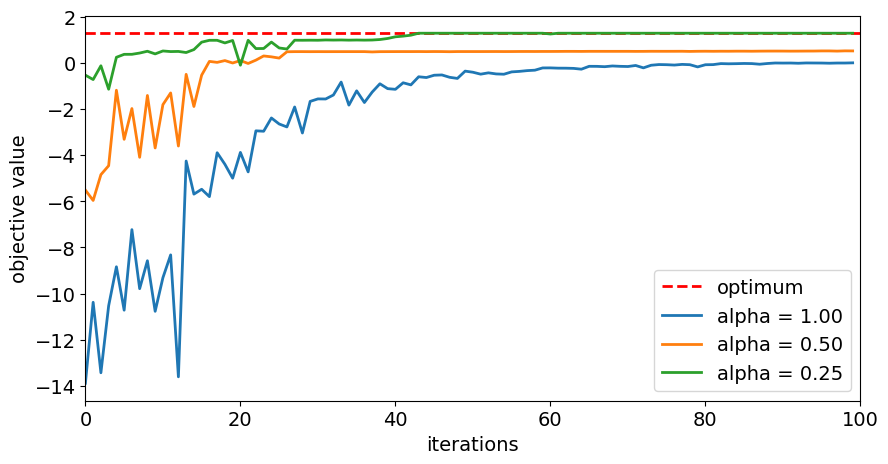

In [16]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [11]:
# evaluate and sort all objective values
objective_values = np.zeros(2**n)
for i in range(2**n):
    x_bin = ("{0:0%sb}" % n).format(i)
    x = [0 if x_ == "0" else 1 for x_ in reversed(x_bin)]
    objective_values[i] = qp.objective.evaluate(x)
ind = np.argsort(objective_values)

# evaluate final optimal probability for each alpha
for alpha in alphas:
    probabilities = np.fromiter(
        results[alpha].min_eigen_solver_result.eigenstate.binary_probabilities().values(),
        dtype=float,
    )
    print("optimal probabilitiy (alpha = %.2f):  %.4f" % (alpha, probabilities[ind][-1:]))

optimal probabilitiy (alpha = 1.00):  0.0000
optimal probabilitiy (alpha = 0.50):  0.0000
optimal probabilitiy (alpha = 0.25):  0.2895


In [12]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright